## KShapeクラスタリング
時系列データにおけるクラスタリング方法<br>
[tslearn](https://github.com/rtavenar/tslearn)にて、実装されている

以下の流れで実行されるアルゴリズムになります。

1. 相互相関測定に基づいた距離尺度を使う（Shape-based distance: SBD）
2. 1.に基づいた時系列クラスタの重心を計算（時系列の形状を保持する新しい重心ベースのクラスタリングアルゴリズム）
3. 各クラスタに分割する方法は一般的なkmeansと同じだが、距離尺度や重心を計算する時に上記1と2を使う

細かい数式や理論については論文を参照下さい。

[J. Paparrizos & L. Gravano. k-Shape: Efficient and Accurate Clustering of Time Series. SIGMOD 2015. pp. 1855-1870.][a]
[a]:http://www1.cs.columbia.edu/~jopa/Papers/PaparrizosSIGMOD2015.pdf

In [1]:
import pandas as pd
import numpy as np
import glob
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def read_filedata(filenames):
    #ファイルデータを読み込み、データフレームを返す
    dfs = []
    for filename in filenames:
        original_df = pd.read_csv(filename, index_col=None, header=0)
        dfs.append(original_df)
    return dfs

def time_series_data(dataframes, target_col=None):
    #データフレームを読み込み、それらを時系列の配列にする
    tsdata = []
    for i, df in enumerate(dataframes):
        tsdata.append(df[target_col].values.tolist()[:])
        #それぞれの時系列データの最大の長さを確認
        len_max = 0
        for ts in tsdata:
            if len(ts) > len_max:
                len_max = len(ts)
        #時系列データの長さを揃えるために、最後のデータを付け加える
        for i, ts in enumerate(tsdata):
            len_add = len_max - len(ts)
            tsdata[i] = ts + [ts[-1]] * len_add
    
    tsdata = np.array(tsdata)
    return tsdata

def transform_vector(time_series_array):
    #ベクトルに変換
    stack_list = []
    for j in range(len(time_series_array)):
        data = np.array(time_series_array[j])
        data = data.reshape((1, len(data))).T
        stack_list.append(data)
    #一次元配列にする
    stack_data = np.stack(stack_list, axis=0)
    return stack_data


filenames = sorted(glob.glob('sample_data/sample_data*.csv'))
df = read_filedata(filenames=filenames)
tsdata = time_series_data(dataframes=df, target_col='data')
stack_data = transform_vector(time_series_array=tsdata)

Init 1
0.015 --> 0.016 --> 
Init 2
Resumed because of empty cluster
Init 2
0.010 --> 0.012 --> 
Init 3
0.019 --> Resumed because of empty cluster
Init 3
0.018 --> 0.018 --> 0.018 --> 
Init 4
0.013 --> 0.013 --> 0.022 --> 
Init 5
Resumed because of empty cluster
Init 5
0.006 --> 0.010 --> 
Init 6
Resumed because of empty cluster
Init 6
0.006 --> 0.010 --> 


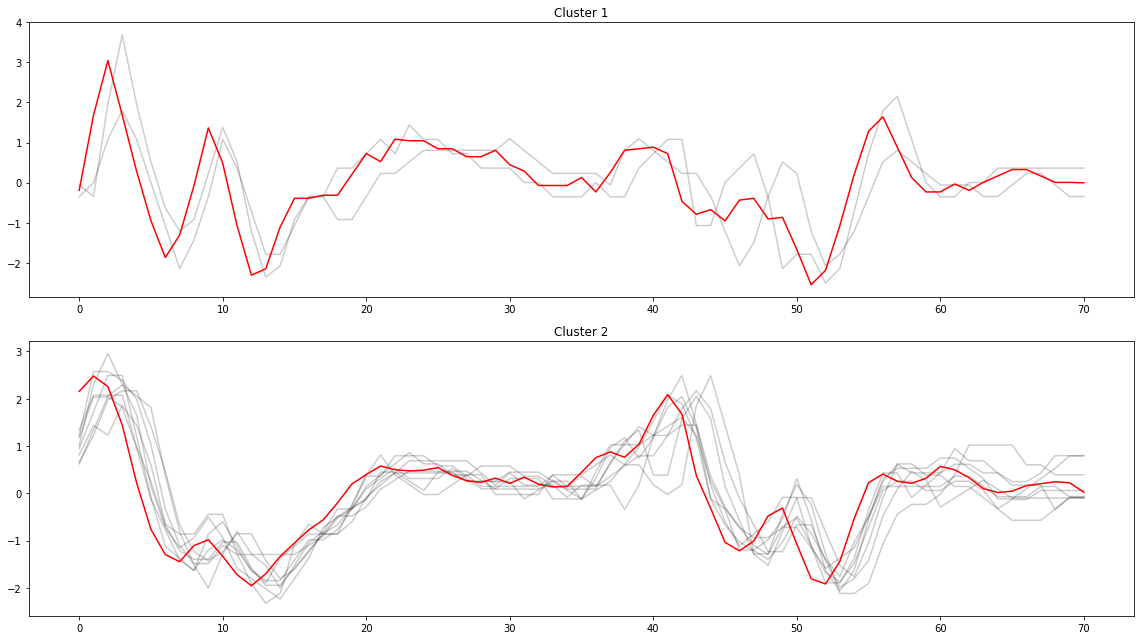

In [8]:
seed = 0
np.random.seed(seed)
#相互相関を計算するために、正規化する必要があります。
#TimeSeriesScalerMeanVarianceがデータを正規化してくれるクラスになります。
stack_data = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0).fit_transform(stack_data)

#KShapeクラスのインスタンス化
ks = KShape(n_clusters=2, n_init=10, verbose=True, random_state=seed)
y_pred = ks.fit_predict(stack_data)

#クラスタリングして可視化
plt.figure(figsize=(16,9))
for yi in range(2):
    plt.subplot(2, 1, 1 + yi)
    for xx in stack_data[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    #plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

## エルボー法によるクラスターの数の計算
エルボー法とは...<br>
各点から割り当てられたクラスタ中心との距離の二乗の合計をクラスタ内誤差平方和（SSE）として計算します。<br>
クラスタ数を変えて、それぞれのSSE値をプロットし、「肘」のように曲がった点を最適なクラスタ数とする方法です。

エルボー法について、wikipediaに記載されています。<br>
[Elbow method (clustering)][a]
[a]:https://en.wikipedia.org/wiki/Elbow_method_(clustering)

Init 1
0.023 --> 0.024 --> 
Init 2
0.022 --> 0.023 --> 
Init 3
0.022 --> 0.022 --> 0.023 --> 
Init 4
0.022 --> 0.022 --> 0.023 --> 
Init 5
0.022 --> 0.023 --> 
Init 6
0.023 --> 0.023 --> 0.033 --> 
Init 7
0.022 --> 0.022 --> 0.023 --> 
Init 8
0.023 --> 0.024 --> 
Init 9
0.023 --> 0.023 --> 
Init 10
0.027 --> 0.023 --> 0.024 --> 
Init 1
0.015 --> 0.016 --> 
Init 2
Resumed because of empty cluster
Init 2
0.010 --> 0.012 --> 
Init 3
0.019 --> Resumed because of empty cluster
Init 3
0.018 --> 0.018 --> 0.018 --> 
Init 4
0.013 --> 0.013 --> 0.022 --> 
Init 5
Resumed because of empty cluster
Init 5
0.006 --> 0.010 --> 
Init 6
Resumed because of empty cluster
Init 6
0.006 --> 0.010 --> 
Init 1
0.009 --> Resumed because of empty cluster
Init 1
0.008 --> 0.009 --> 
Init 2
0.015 --> Resumed because of empty cluster
Init 2
0.010 --> 0.009 --> 0.016 --> 
Init 3
Resumed because of empty cluster
Init 3
Resumed because of empty cluster
Init 3
0.004 --> 0.007 --> 
Init 4
Resumed because of empty clust

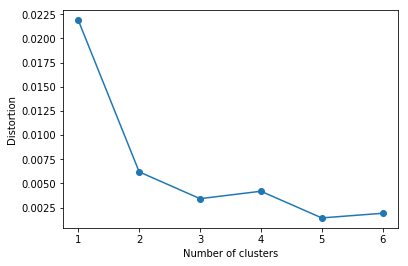

In [5]:
distortions = []

#1~10クラスタまで計算 
for i  in range(1,11):
    ks = KShape(n_clusters=i, n_init=10, verbose=True, random_state=seed)
    #クラスタリングの計算を実行
    ks.fit(stack_data)
    #ks.fitするとks.inertia_が得られる
    distortions.append(ks.inertia_)

plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()